In [96]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree
from sklearn.decomposition import KernelPCA
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

plt.rcParams['figure.figsize']=[12,8]

### Problem Statement
#### Analysis of the housing dataset to understand the availability, demand and pricing for various types of housing in Bangalore.

## About the Dataset
##### AREA_TYPE : The type of the area where the property is located
##### AVAILABILITY : Whether the property is available currently or not
##### LOCATION : Location where the property is situtated
##### SIZE : Number of Bedrooms
##### SOCIETY : The type of society where the property is located
##### TOTAL_SQFT : Total Square feet of the property
##### BATH : Number of Bathrooms
##### BALCONY : Number of Balconies
##### PRICE : Price of the property in Lakhs

## Reading Data

In [97]:
df=pd.read_csv('Bengaluru_House_Data_Latest.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600.0,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00


In [98]:
df.tail()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
13312,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453.0,4.0,0.0,231.0
13313,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600.0,5.0,NaN,400.0
13314,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141.0,2.0,1.0,60.0
13315,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689.0,4.0,1.0,488.0
13316,Super built-up Area,Ready To Move,Doddathoguru,1 BHK,NaN,550.0,1.0,1.0,17.0


In [99]:
df.shape

(13317, 9)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13317 entries, 0 to 13316
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13287 non-null  object 
 1   availability  13287 non-null  object 
 2   location      13286 non-null  object 
 3   size          13271 non-null  object 
 4   society       7807 non-null   object 
 5   total_sqft    13287 non-null  float64
 6   bath          13214 non-null  float64
 7   balcony       12679 non-null  float64
 8   price         13287 non-null  float64
dtypes: float64(4), object(5)
memory usage: 936.5+ KB


## Analysing Missing Values

In [101]:
df.isnull().sum()

area_type         30
availability      30
location          31
size              46
society         5510
total_sqft        30
bath             103
balcony          638
price             30
dtype: int64

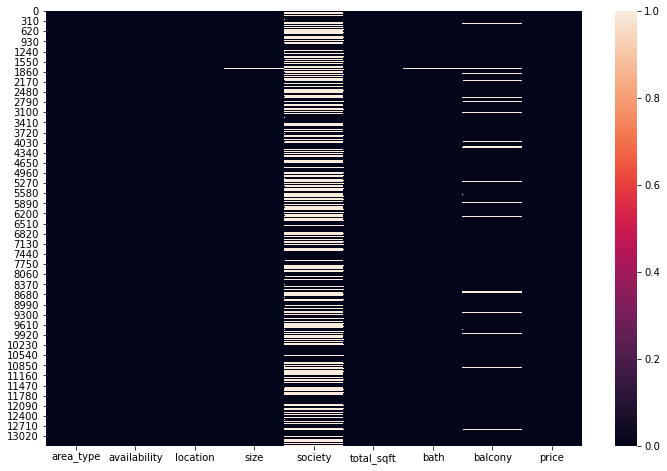

In [102]:
sns.heatmap(df.isnull())

In [103]:
(df.isnull().sum()/len(df))*100

area_type        0.225276
availability     0.225276
location         0.232785
size             0.345423
society         41.375685
total_sqft       0.225276
bath             0.773447
balcony          4.790869
price            0.225276
dtype: float64

## Categorical Variables

In [104]:
#40% of the data is missing so droping the column
df.drop('society',axis=1,inplace=True)

In [105]:
df.location.replace(to_replace=np.NaN,value=df.location.mode()[0],inplace=True)
df.area_type.replace(to_replace=np.NaN,value=df.area_type.mode()[0],inplace=True)

In [106]:
df['size']=df['size'].str.split(' ',expand=True)[0].astype(np.number)
df.bath=df.bath.astype(np.number)

In [107]:
df.availability=(df.availability=='Ready To Move')
df.availability.replace({True:1,False:0},inplace=True)
df.availability=df.availability.astype(object)
df.availability.head()

0    0
1    1
2    1
3    1
4    1
Name: availability, dtype: object

In [108]:
df.isnull().sum() 

area_type         0
availability      0
location          0
size             46
total_sqft       30
bath            103
balcony         638
price            30
dtype: int64

## Numerical Variables

In [109]:
df_cat=df.select_dtypes(object)
df_cat.head(1)

,area_type,availability,location
0,Super built-up Area,0,Electronic City Phase II


In [110]:
df_num=df.select_dtypes(np.number)
df_num.head(1)

,size,total_sqft,bath,balcony,price
0,2.0,1056.0,2.0,1.0,39.07


In [111]:
imputer = KNNImputer()

# fit on the dataset
imputer.fit(df_num)

# transform the dataset
df_num_impute = pd.DataFrame(imputer.transform(df_num),columns=df_num.columns)

In [112]:
df=pd.concat([df_cat,df_num_impute],axis=1)

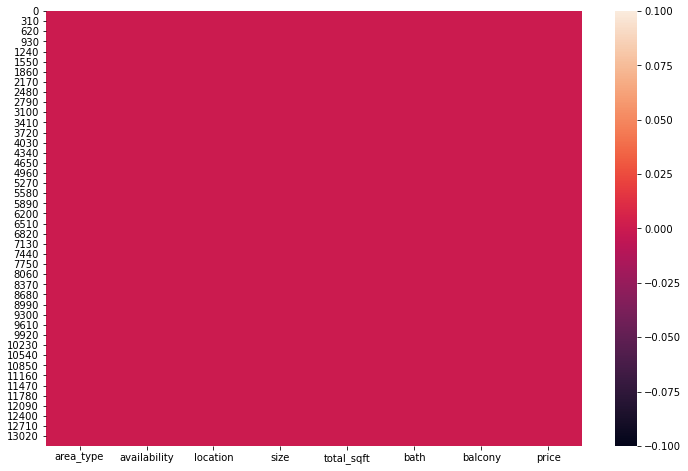

In [113]:
sns.heatmap(df.isnull())

In [114]:
(df.isnull().sum()/len(df))*100

area_type       0.0
availability    0.0
location        0.0
size            0.0
total_sqft      0.0
bath            0.0
balcony         0.0
price           0.0
dtype: float64

## Removing Outliers

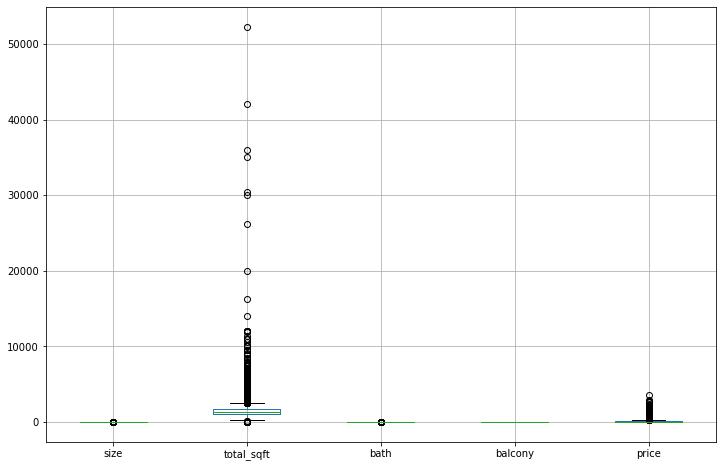

In [115]:
df.boxplot()

In [116]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3-q1
IQR

df = df[~((df) > (q3 + (1.5 * IQR))).any(axis=1)]

df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,0,Electronic City Phase II,2.0,1056.0,2.0,1.0,39.07
2,Built-up Area,1,Uttarahalli,3.0,1440.0,2.0,3.0,62.00
3,Super built-up Area,1,Lingadheeranahalli,3.0,1521.0,3.0,1.0,95.00
4,Super built-up Area,1,Kothanur,2.0,1200.0,2.0,1.0,51.00
5,Super built-up Area,1,Whitefield,2.0,1170.0,2.0,1.0,38.00


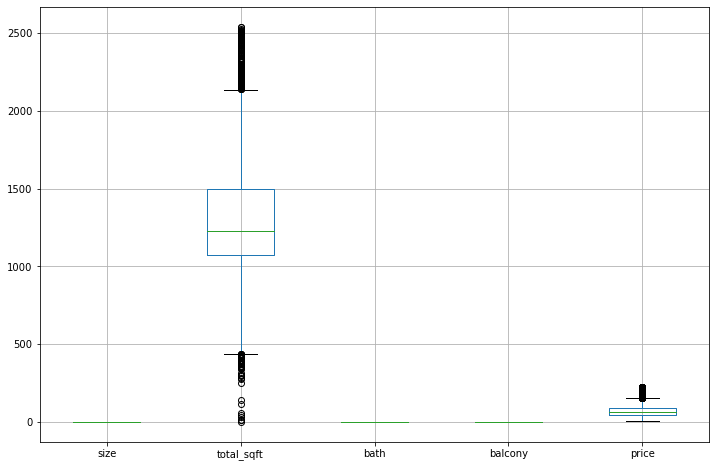

In [117]:
df.boxplot()

In [118]:
df.shape

(11120, 8)

## EDA

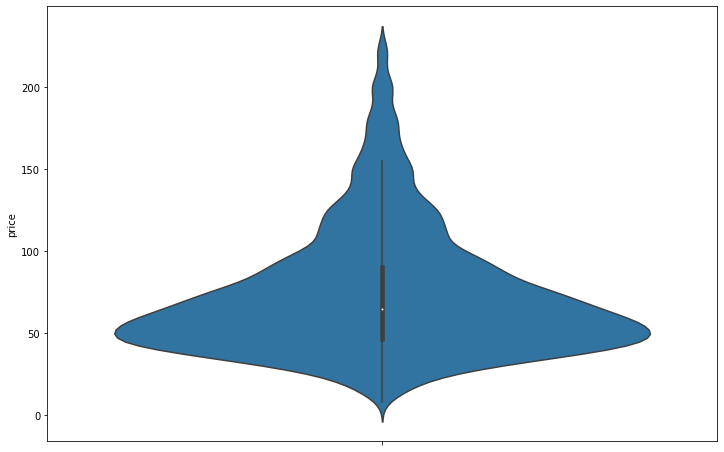

In [119]:
sns.violinplot(y = df.price)

Text(0, 0.5, 'Availability of Rooms')

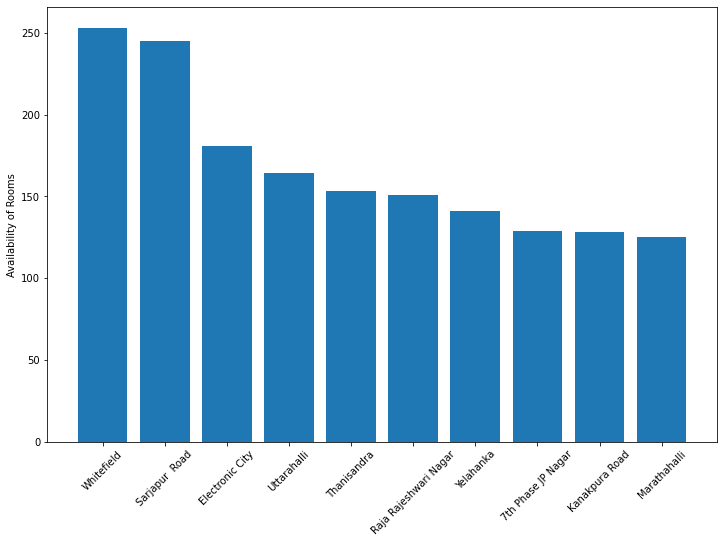

In [120]:
plt.bar(x=df[df['availability'] == 1].groupby('location')['availability'].agg('count').sort_values(ascending=False).head(10).index,height=df[df['availability'] == 1].groupby('location')['availability'].agg('count').sort_values(ascending=False).head(10))
plt.xticks(rotation=45)
plt.ylabel('Availability of Rooms')

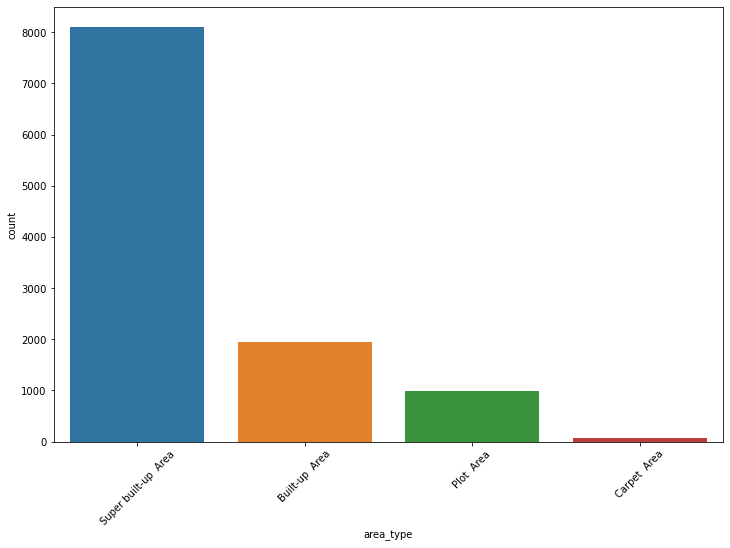

In [121]:
sns.countplot(df.area_type)
plt.xticks(rotation = 45)
plt.show()

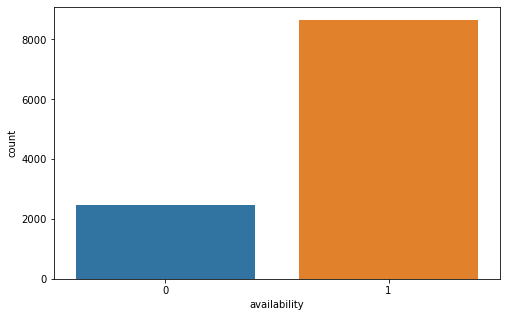

In [122]:
plt.figure(figsize=(8,5))
sns.countplot(df.availability)
plt.show()

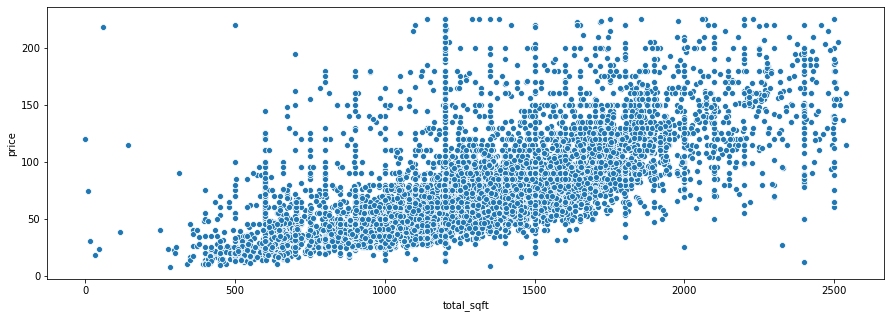

In [123]:
plt.figure(figsize=(15,5))
sns.scatterplot(x="total_sqft", y="price", data=df)
plt.show()

Text(0.5, 0, 'Number of Bedrooms')

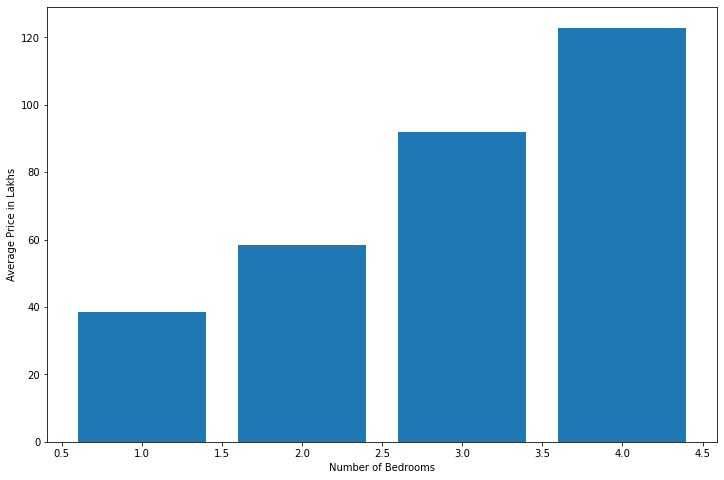

In [124]:
df10 = df.copy()
df10['size'] = np.round(df10['size'])
plt.bar(x=df10.groupby('size')['price'].agg('mean').sort_values(ascending=False).head(10).index,height=df10.groupby('size')['price'].agg('mean').sort_values(ascending=False).head(10))
plt.ylabel('Average Price in Lakhs')
plt.xlabel('Number of Bedrooms')

In [125]:
# Costliest locations in Bangalore

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

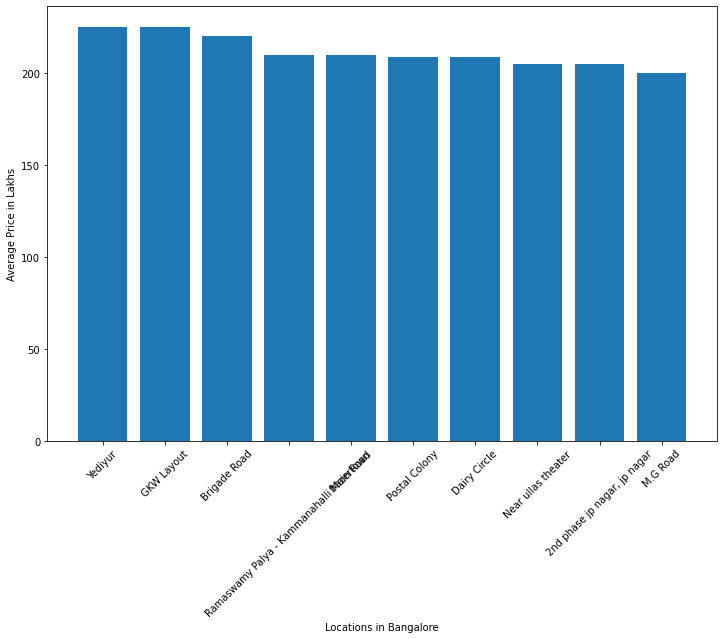

In [126]:
plt.bar(x=df.groupby(by='location')['price'].agg('mean').sort_values(ascending=False).head(10).index,height=df.groupby(by='location')['price'].agg('mean').sort_values(ascending=False).head(10))
plt.xlabel('Locations in Bangalore')
plt.ylabel('Average Price in Lakhs')
plt.xticks(rotation=45)

In [127]:
# Costliest Per sq.ft price in bglore

In [128]:
df['per_sqft'] = df['price']/df['total_sqft']

Text(0, 0.5, 'Average Price / Sq.ft in Lakhs')

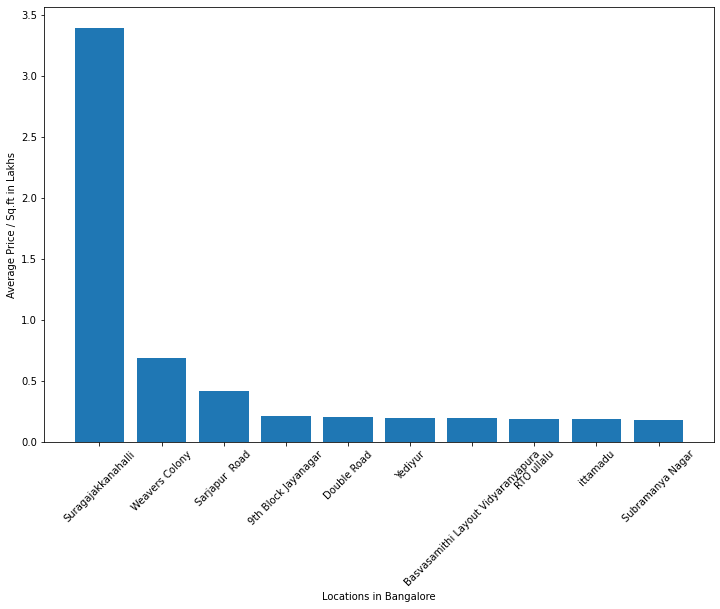

In [129]:
plt.bar(x=df.groupby(by='location')['per_sqft'].agg('mean').sort_values(ascending=False).head(10).index,height=df.groupby(by='location')['per_sqft'].agg('mean').sort_values(ascending=False).head(10))
plt.xticks(rotation = 45)
plt.xlabel('Locations in Bangalore')
plt.ylabel('Average Price / Sq.ft in Lakhs')

In [130]:
df = df.drop('per_sqft',axis=1)

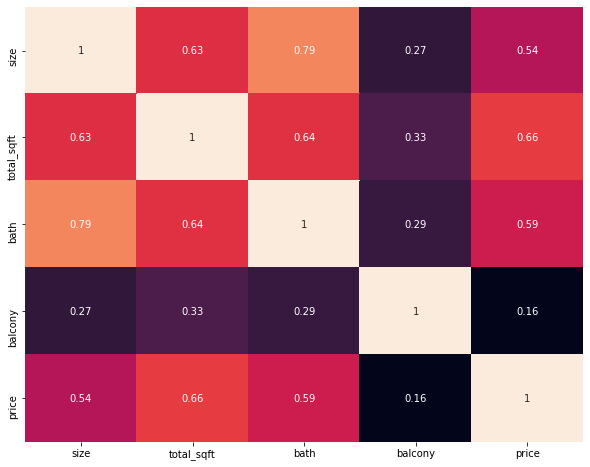

In [131]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True,cbar=False)
plt.show()

## Standardisation

In [132]:
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,0,Electronic City Phase II,2.0,1056.0,2.0,1.0,39.07
2,Built-up Area,1,Uttarahalli,3.0,1440.0,2.0,3.0,62.00
3,Super built-up Area,1,Lingadheeranahalli,3.0,1521.0,3.0,1.0,95.00
4,Super built-up Area,1,Kothanur,2.0,1200.0,2.0,1.0,51.00
5,Super built-up Area,1,Whitefield,2.0,1170.0,2.0,1.0,38.00


In [133]:
data_cat=df.select_dtypes(exclude=np.number)
data_num=df.select_dtypes(np.number)
data_cat=data_cat.reset_index()

In [134]:
ss=StandardScaler()
data_num_scaled=pd.DataFrame(ss.fit_transform(data_num),columns=data_num.columns)
data_num_scaled=data_num_scaled.reset_index()
data_num_scaled.head()

,index,size,total_sqft,bath,balcony,price
0,0,-0.649410,-0.624846,-0.440965,-0.715699,-0.903515
1,1,0.837003,0.386558,-0.440965,1.862747,-0.306717
2,2,0.837003,0.599901,1.063850,-0.715699,0.552174
3,3,-0.649410,-0.245570,-0.440965,-0.715699,-0.593013
4,4,-0.649410,-0.324586,-0.440965,-0.715699,-0.931364


In [135]:
data_scaled=pd.concat([data_num_scaled,data_cat],axis=1).drop('index',axis=1)
data_scaled.head()

,size,total_sqft,bath,balcony,price,area_type,availability,location
0,-0.649410,-0.624846,-0.440965,-0.715699,-0.903515,Super built-up Area,0,Electronic City Phase II
1,0.837003,0.386558,-0.440965,1.862747,-0.306717,Built-up Area,1,Uttarahalli
2,0.837003,0.599901,1.063850,-0.715699,0.552174,Super built-up Area,1,Lingadheeranahalli
3,-0.649410,-0.245570,-0.440965,-0.715699,-0.593013,Super built-up Area,1,Kothanur
4,-0.649410,-0.324586,-0.440965,-0.715699,-0.931364,Super built-up Area,1,Whitefield


## Encoding

In [136]:
# Reference Table For Displaying Reason for Selecting
data_encoded_refernce=pd.get_dummies(df,columns=['area_type','location'])
data_encoded_refernce.head()

,availability,size,total_sqft,bath,balcony,price,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,...,location_mvj engineering college,location_pavitra paradise,location_poornaprajna layout,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_singapura paradise,location_tc.palya,location_whitefiled
0,0,2.0,1056.0,2.0,1.0,39.07,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3.0,1440.0,2.0,3.0,62.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3.0,1521.0,3.0,1.0,95.00,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2.0,1200.0,2.0,1.0,51.00,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,2.0,1170.0,2.0,1.0,38.00,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [137]:
data_encoded_scaled=pd.get_dummies(data_scaled,columns=['area_type','location'])
data_encoded_scaled.head()

,size,total_sqft,bath,balcony,price,availability,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,...,location_mvj engineering college,location_pavitra paradise,location_poornaprajna layout,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_singapura paradise,location_tc.palya,location_whitefiled
0,-0.649410,-0.624846,-0.440965,-0.715699,-0.903515,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.837003,0.386558,-0.440965,1.862747,-0.306717,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.837003,0.599901,1.063850,-0.715699,0.552174,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.649410,-0.245570,-0.440965,-0.715699,-0.593013,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-0.649410,-0.324586,-0.440965,-0.715699,-0.931364,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Hierarchical Clustering

In [138]:
d1 = data_encoded_scaled.copy()

In [139]:
data_cluster=data_encoded_refernce.copy()

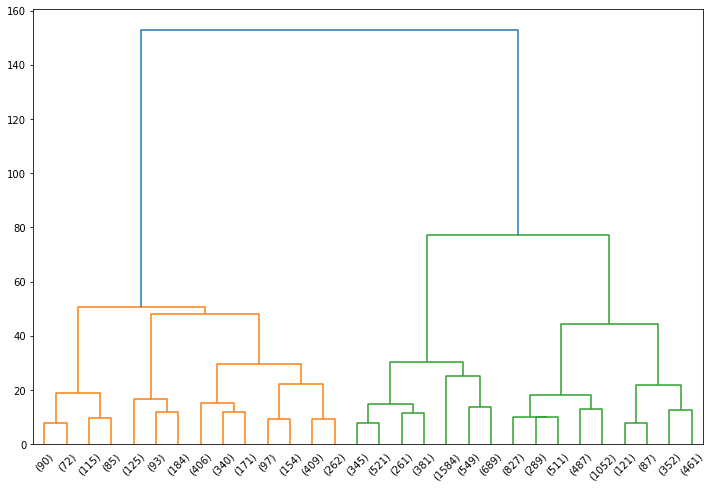

In [140]:
cls=d1[['total_sqft','price']]
mergings=linkage(cls,method='ward',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp')
plt.show()

In [141]:
cluster=cut_tree(mergings,n_clusters=3)

In [142]:
cluster_cut = pd.Series(cut_tree(mergings,n_clusters=3).reshape(-1))

In [143]:
cluster_cut.value_counts()

1    4330
0    4187
2    2603
dtype: int64

In [144]:
d1['cluster']=cluster

In [145]:
data_cluster['cluster']=cluster

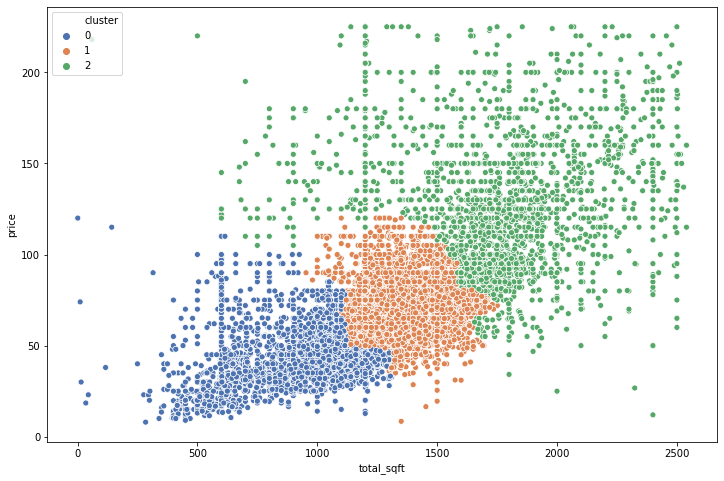

In [146]:
sns.scatterplot(y=df.price,x=df['total_sqft'],hue=data_cluster['cluster'],palette='deep')

# KMEANS Clustering

In [147]:
ssd = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=4)
    kmeans.fit(cls)
    ssd.append(kmeans.inertia_)

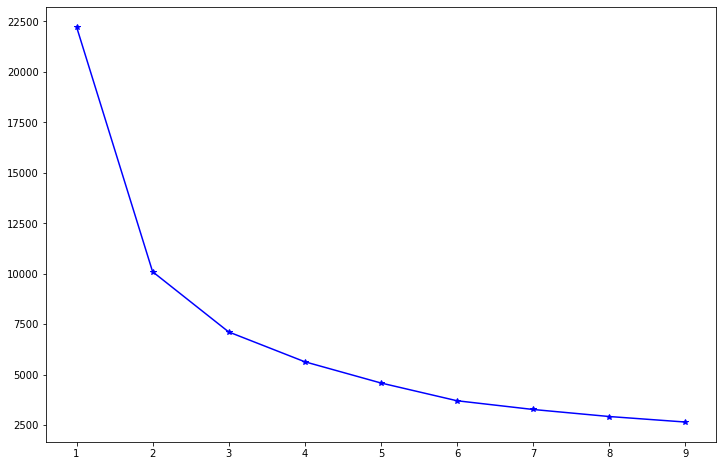

In [148]:
plt.plot(range(1,10),ssd,marker='*',color='b')

In [149]:
from sklearn.metrics import silhouette_score

score = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,random_state=4)
    kmeans.fit(cls)
    labels = kmeans.labels_
    ss = silhouette_score(d1,labels)
    score.append(ss)

Text(0.5, 0, 'no of clusters')

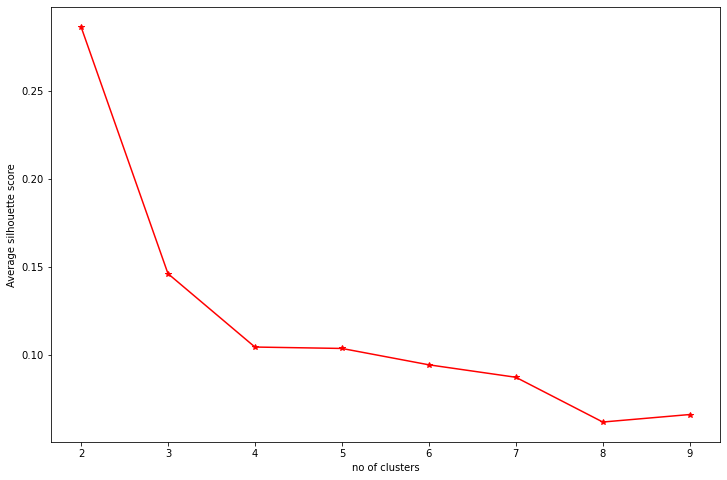

In [150]:
plt.plot(range(2,10),score,marker='*',color='r')
plt.ylabel('Average silhouette score')
plt.xlabel('no of clusters')

In [151]:
def svisualizer(x, ncluster):
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    import numpy as np
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples

    km = KMeans(n_clusters=ncluster, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(x)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(x, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0

    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    plt.show()	

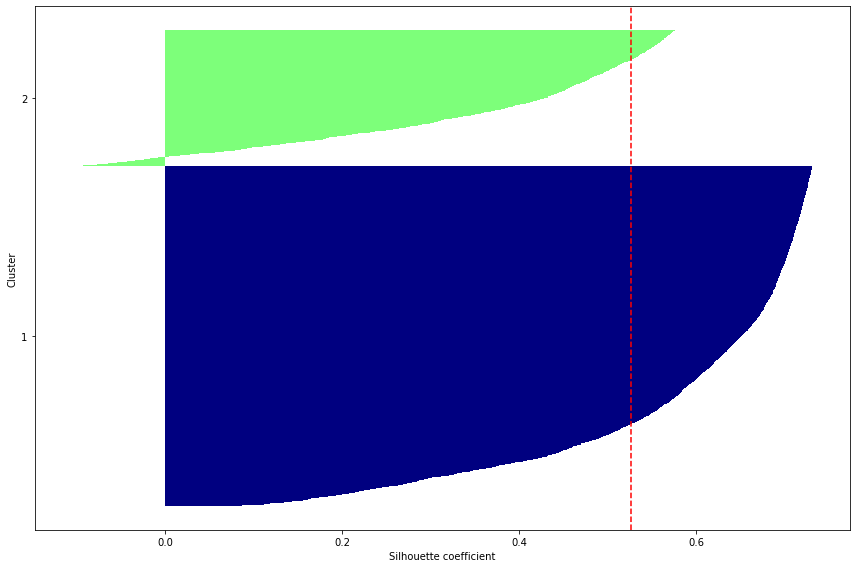

In [152]:
svisualizer(cls,2)

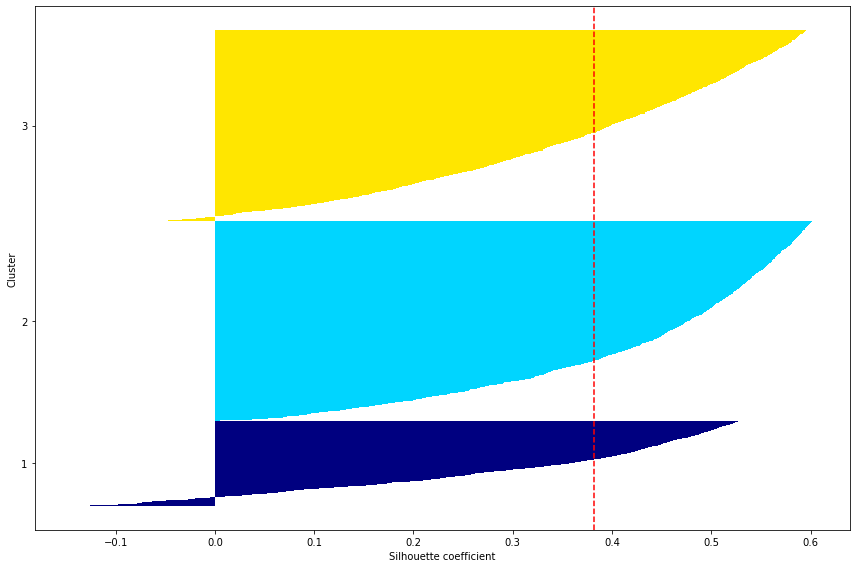

In [153]:
svisualizer(cls,3)

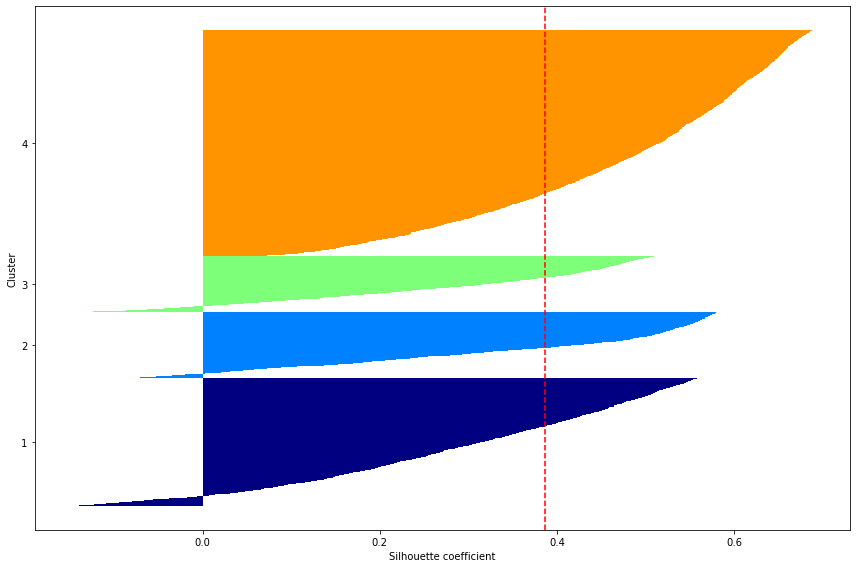

In [154]:
svisualizer(cls,4)

In [155]:
model=KMeans(n_clusters=3,random_state=10)
cluster_kmeans=model.fit_predict(data_encoded_refernce)
data_cluster['kmeans_cluster']=cluster_kmeans
data_cluster.head()

,availability,size,total_sqft,bath,balcony,price,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,...,location_poornaprajna layout,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_singapura paradise,location_tc.palya,location_whitefiled,cluster,kmeans_cluster
0,0,2.0,1056.0,2.0,1.0,39.07,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3.0,1440.0,2.0,3.0,62.00,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,3.0,1521.0,3.0,1.0,95.00,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
4,1,2.0,1200.0,2.0,1.0,51.00,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,1,2.0,1170.0,2.0,1.0,38.00,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [156]:
df3 = data_cluster.iloc[:,[0,1,2,3,4,5,1119]]

In [157]:
df4 = df3.groupby(by='kmeans_cluster')
df4[['size','bath','balcony','total_sqft','price']].mean()

,size,bath,balcony,total_sqft,price
kmeans_cluster,,,,,
0,2.341520,2.159438,1.534669,1225.221968,65.278472
1,3.049944,2.966886,1.916830,1809.807419,112.709475
2,1.849394,1.758223,1.070398,750.521968,45.934325


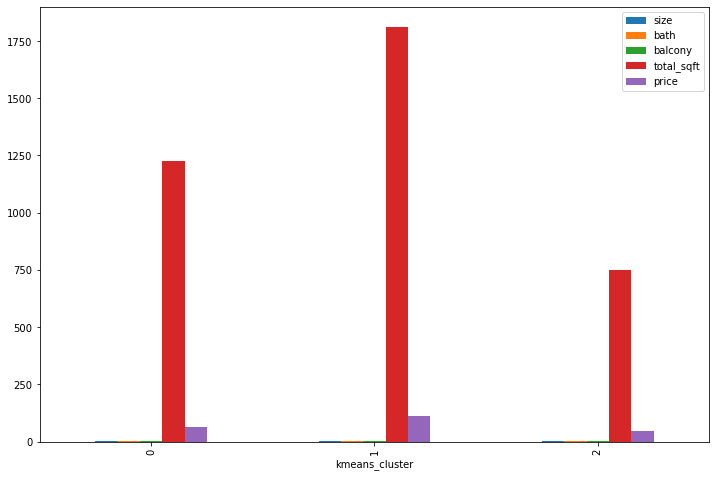

In [158]:
df4[['size','bath','balcony','total_sqft','price']].mean().plot.bar()
plt.show()

In [159]:
def cluster_plot(data, nclusters):
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    X = data.copy()
    cols = list(X.columns)
    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)


    # Visualize it:
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))

    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', label='centroids')
    plt.xlabel(cols[0])
    plt.ylabel(cols[1])
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

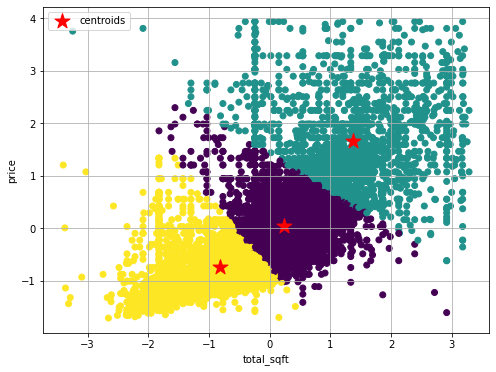

In [160]:
cluster_plot(cls,3)

### DBSCAN

In [161]:
from sklearn.cluster import DBSCAN

In [162]:
dbscan = DBSCAN(eps=0.25,min_samples=4)

dbscan.fit(cls)

pd.Series(dbscan.labels_).value_counts()

 0    11075
-1       29
 3        7
 1        6
 2        3
dtype: int64

In [163]:
lbl = pd.Series(dbscan.labels_)
lbl.loc[lbl >= 0] = 0
lbl.value_counts()

 0    11091
-1       29
dtype: int64

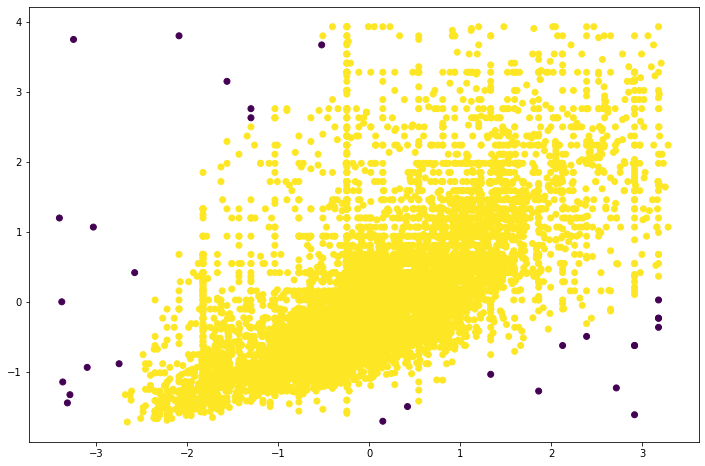

In [164]:
plt.scatter(cls['total_sqft'],cls['price'],c=lbl)

## Principal Component Analysis(PCA)

In [165]:
d2 = data_num_scaled.drop(['index'],axis=1)

In [166]:
d2.head()

,size,total_sqft,bath,balcony,price
0,-0.649410,-0.624846,-0.440965,-0.715699,-0.903515
1,0.837003,0.386558,-0.440965,1.862747,-0.306717
2,0.837003,0.599901,1.063850,-0.715699,0.552174
3,-0.649410,-0.245570,-0.440965,-0.715699,-0.593013
4,-0.649410,-0.324586,-0.440965,-0.715699,-0.931364


In [167]:
from sklearn.decomposition import PCA

pca=PCA()
pca.fit(d2)

print(np.cumsum(pca.explained_variance_ratio_*100))

[ 61.26419718  78.95134173  89.64037079  95.897461   100.        ]


In [168]:
pca=PCA(n_components=2)
pca.fit_transform(d2)

print(pca.explained_variance_ratio_*100)


[61.26419718 17.68714455]


In [169]:
components = pca.components_.T
pd.DataFrame(components,index=d2.columns,columns=['PC1','PC2'])

,PC1,PC2
size,0.492645,0.092128
total_sqft,0.490447,0.025868
bath,0.503375,0.094173
balcony,0.250660,-0.946288
price,0.447823,0.294133


In [170]:
data_pca=pd.DataFrame(pca.transform(d2),columns=['PC1','PC2'])
data_pca

,PC1,PC2
0,-1.432366,0.293985
1,0.709523,-1.807326
2,1.309959,1.032485
3,-1.107301,0.395125
4,-1.297575,0.293561
...,...,...
11115,-0.750676,-0.851249
11116,-0.117787,0.587876
11117,2.405020,-1.264107
11118,-1.078616,0.460003


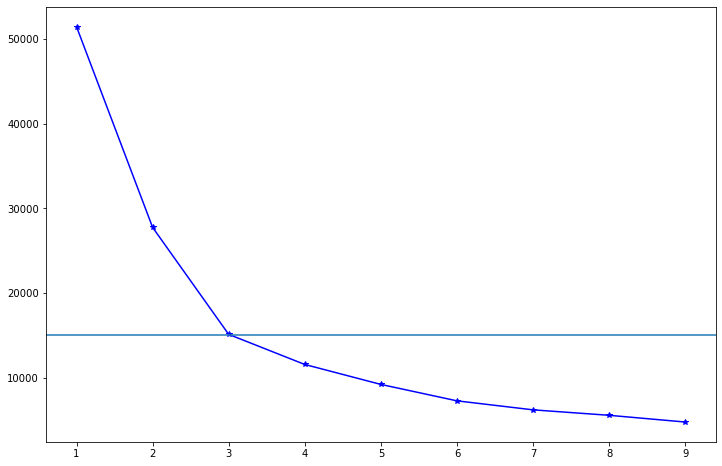

In [173]:
ssd = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=4)
    kmeans.fit(data_pca)
    ssd.append(kmeans.inertia_)

plt.plot(range(1,10),ssd,marker='*',color='b')
plt.axhline(15000)
plt.show()

In [171]:
model=KMeans(n_clusters=3,random_state=10)
cluster_kmeans=model.fit_predict(data_pca)
data_pca['km_cluster_pca']=cluster_kmeans

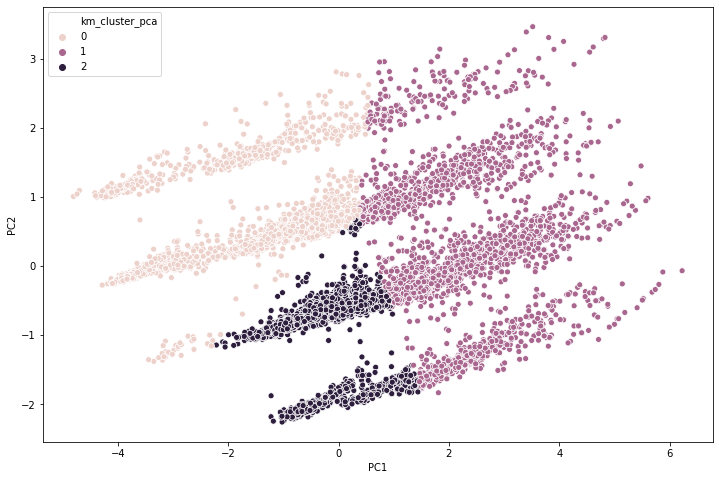

In [174]:
sns.scatterplot(x=data_pca['PC1'],y=data_pca['PC2'],hue=data_pca['km_cluster_pca'])

# Recommendation Systems

## Content Based Filter

In [175]:
model=NearestNeighbors(metric='cosine')
model.fit(data_encoded_scaled)

NearestNeighbors(metric='cosine')

In [176]:
selected=7

In [177]:
data_encoded_scaled.iloc[selected].values[0:8]

array([-0.6494104492898559, -0.7723427482299117, -0.44096466513403765,
       -0.7156992001052467, -0.9313640361496651, 1, 0, 0], dtype=object)

In [178]:
dist,index=model.kneighbors(data_encoded_scaled.iloc[selected].values.reshape(1,-1),n_neighbors=6)
index

array([[   7, 9387, 2171, 5186,  712, 1309]], dtype=int64)

In [179]:
suggest=[]
for x in index:
    suggest.append(x)
suggest

[array([   7, 9387, 2171, 5186,  712, 1309], dtype=int64)]

In [180]:
data_encoded_refernce = data_encoded_refernce.reset_index()
data_encoded_refernce = data_encoded_refernce.drop('index',axis=1)

## Example 1

In [181]:
# Apartment user showed intrest in
r=data_encoded_refernce.iloc[[selected]][data_encoded_refernce.iloc[[selected]]>0].dropna(axis=1)
r

,availability,size,total_sqft,bath,balcony,price,area_type_Super built-up Area,location_7th Phase JP Nagar
7,1,2.0,1000.0,2.0,1.0,38.0,1,1


In [182]:
# Availabilty - 1           --> Ready to move
# Size        - 2           --> 2 BKH Apartment
# Total SqFt  - 1000        --> 1000 Sqft Apartment
# Price       - 38          --> Apartment price 38
# bath        - 2           --> Apartment with 2 bathrooms
# balcony     - 1           --> Apartment with 1 Balcony
# location    - JP Nagar    --> Apartment Near JP Nagar

In [183]:
# Similar Reccomendations
col=r.columns
for x in index:
    suggestions=data_encoded_refernce.iloc[list(x)][col]
suggestions

,availability,size,total_sqft,bath,balcony,price,area_type_Super built-up Area,location_7th Phase JP Nagar
7,1,2.0,1000.0,2.0,1.0,38.00,1,1
9387,1,2.0,1035.0,2.0,1.0,39.33,1,1
2171,1,2.0,1035.0,2.0,1.0,39.33,1,1
5186,1,2.0,1035.0,2.0,1.0,39.33,1,1
712,1,2.0,1040.0,2.0,1.0,39.52,1,1
1309,1,2.0,1035.0,2.0,1.0,41.39,1,1


## Example 2

In [184]:
selected=125

data_encoded_scaled.iloc[selected].values[0:8]

dist,index=model.kneighbors(data_encoded_scaled.iloc[selected].values.reshape(1,-1),n_neighbors=6)
index

suggest=[]
for x in index:
    suggest.append(x)
suggest

# Apartment user showed intrest in
r=data_encoded_refernce.iloc[[selected]][data_encoded_refernce.iloc[[selected]]>0].dropna(axis=1)
r

,size,total_sqft,bath,balcony,price,area_type_Super built-up Area,location_Electronic City Phase II
125,2.0,1020.0,2.0,1.0,30.6,1,1


In [185]:
# Size        - 2                           --> 2 BKH Apartment
# Total SqFt  - 1020                        --> 1020 Sqft Apartment
# Price       - 30.6                        --> Apartment price 30.6
# bath        - 2                           --> Apartment with 2 bathrooms
# balcony     - 1                           --> Apartment with 1 Balcony
# location    - Electronic City Phase II    --> Apartment Near Electronic City Phase II

In [186]:
# Similar Reccomendations
col=r.columns
for x in index:
    suggestions=data_encoded_refernce.iloc[list(x)][col]
suggestions

,size,total_sqft,bath,balcony,price,area_type_Super built-up Area,location_Electronic City Phase II
125,2.0,1020.0,2.0,1.0,30.60,1,1
5036,2.0,1000.0,2.0,1.0,28.88,1,1
5034,2.0,1000.0,2.0,1.0,28.88,1,1
1399,2.0,1000.0,2.0,1.0,28.88,1,1
6970,2.0,1020.0,2.0,1.0,27.43,1,1
2793,2.0,1065.0,2.0,1.0,30.75,1,1


----------------------------------------------THANK YOU--------------------------------------------------------------------